In [31]:
import sys
import cv2
import os
import gc
import sqlite3
import shutil

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from torch.utils.data import DataLoader, Dataset

sys.path.insert(0, "../")
from db import HindsightDB
import utils

In [2]:
db = HindsightDB()

In [3]:
frames_df = db.get_frames()

In [4]:
frames_df = frames_df.loc[frames_df['application'] == 'Whatsapp']

In [5]:
frames_df = frames_df.loc[frames_df['path'].str.contains('/Users/connorparish/')]

In [6]:
frames = list()
for path in frames_df['path']:
    frames.append(cv2.imread(path))

In [7]:
def preprocess_frame(frame):
    # frame = cv2.resize(frame, (0, 0), fx = 0.1, fy = 0.1)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

In [8]:
proc_frames = [preprocess_frame(f) for f in frames]

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, device):
        super(FeatureExtractor, self).__init__()
        self.device = device
        efficientnet = torch.hub.load(
            'NVIDIA/DeepLearningExamples:torchhub', 
            'nvidia_efficientnet_b0', 
            pretrained=True
        )

        # Ensure the model is on the correct device
        efficientnet = efficientnet.to(self.device)
        echildren = list(efficientnet.children())
        self.feature_extractor = torch.nn.Sequential(*echildren[:-1]).to(self.device)
        self.pre_final_stage = torch.nn.Sequential(*echildren[-1][:-1]).to(self.device)
    
    def forward(self, data):
        data = data.to(self.device)  # Move data to the device
        feats = self.feature_extractor(data)
        feats = self.pre_final_stage(feats)
        return feats

In [10]:
device = "mps"
cnn_model = FeatureExtractor(device=device)

Using cache found in /Users/connorparish/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/Users/connorparish/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/Users/connorparish/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [13]:
batch_size = 10

In [14]:
torch.cuda.empty_cache()  # Clear unused memory, though more relevant for CUDA
gc.collect()  # Collect garbage to free memory

0

In [16]:
def create_batches(data, batch_size):
    """ Yield successive n-sized chunks from l. """
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

embeddings = list()
# Process each batch manually
for frames_batch in create_batches(proc_frames, batch_size):
    print("batch")
    frames_tensor = torch.from_numpy(np.array(frames_batch)).float() 
    frames_tensor = frames_tensor.permute(0, 3, 1, 2)
    with torch.no_grad():
        frames_tensor = frames_tensor.to(device)  # Move batch to the device (MPS or CPU)
        output = cnn_model(frames_tensor)
    embeddings.append(output)

batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batch
batc

In [17]:
all_embeddings = torch.cat(embeddings, dim=0)
all_embeddings_cpu = all_embeddings.detach().cpu()
embeddings_np = all_embeddings_cpu.numpy()

# Cluster embeddings

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
embeddings_standardized = StandardScaler().fit_transform(embeddings_np)
kmeanModel = KMeans(n_clusters=3).fit(embeddings_standardized)

/Users/connorparish/miniconda3/envs/hindsight_exp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
frames_df['embed_cluster'] = kmeanModel.labels_

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings_standardized)
frames_df['pca_x'] = X_pca[:,0]
frames_df['pca_y'] = X_pca[:,1]

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_66958/2609393608.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='pca_x', y='pca_y', data=frames_df, palette=sns.color_palette(cc.glasbey, n_colors=25))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


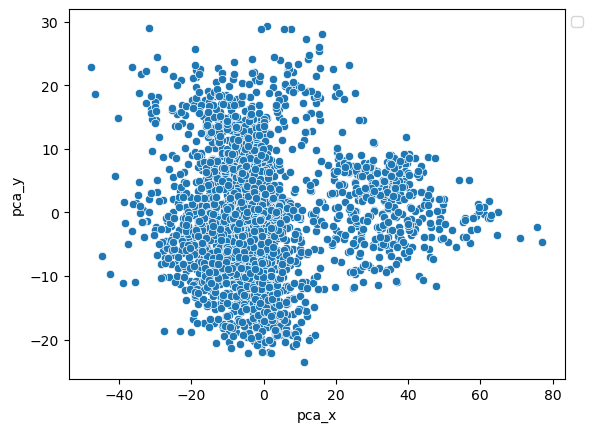

In [26]:
sns.scatterplot(x='pca_x', y='pca_y', data=frames_df, palette=sns.color_palette(cc.glasbey, n_colors=25))
plt.legend(bbox_to_anchor=(1.05, 1))

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_66958/431699240.py:1: UserWarning: The palette list has more values (25) than needed (3), which may not be intended.
  sns.scatterplot(x='pca_x', y='pca_y', hue='embed_cluster', data=frames_df, palette=sns.color_palette(cc.glasbey, n_colors=25))


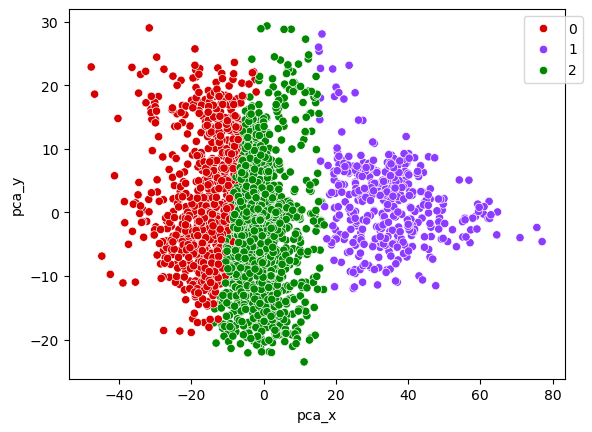

In [27]:
sns.scatterplot(x='pca_x', y='pca_y', hue='embed_cluster', data=frames_df, palette=sns.color_palette(cc.glasbey, n_colors=25))
plt.legend(bbox_to_anchor=(1.05, 1))

In [28]:
df = frames_df.reset_index(drop=True)

In [32]:
clusters_dir = '../testing_data/screenshot_clusters/'
for i, row in df.iterrows():
    cluster_dir = os.path.join(clusters_dir, str(row['embed_cluster']))
    utils.make_dir(cluster_dir)
    filename = row['path'].split('/')[-1]
    filepath = os.path.join(cluster_dir, filename)
    shutil.copy(row['path'], filepath)

: 

In [95]:
df.loc[df['embed_cluster'] == 1]

,chunksFramesIndex,chunkId,filePath,frameId,timestamp,activeApplicationName,offsetIndex,embed_cluster,pca_x,pca_y
3,31260,1197,/Users/connorparish/Library/Containers/today.j...,31347,2024-05-02T20:15:41.804,Code,2,1,-10.519938,-13.744675
4,31261,1197,/Users/connorparish/Library/Containers/today.j...,31348,2024-05-02T20:16:17.841,Code,3,1,-9.617958,-13.127402
32,31339,1199,/Users/connorparish/Library/Containers/today.j...,31426,2024-05-02T20:21:52.274,Firefox,21,1,-18.940981,7.891105
71,31691,1211,/Users/connorparish/Library/Containers/today.j...,31778,2024-05-02T20:40:12.275,Firefox,13,1,-14.272152,3.410240
90,31746,1213,/Users/connorparish/Library/Containers/today.j...,31833,2024-05-02T20:42:49.973,Firefox,8,1,-9.526859,1.247894
130,31858,1217,/Users/connorparish/Library/Containers/today.j...,31945,2024-05-02T20:50:32.702,Firefox,0,1,-9.434364,0.660355
135,31875,1218,/Users/connorparish/Library/Containers/today.j...,31962,2024-05-02T21:35:57.732,rem,0,1,-14.362974,-1.302917
212,32454,1240,/Users/connorparish/Library/Containers/today.j...,32541,2024-05-03T15:06:16.776,Code,29,1,-15.752714,-5.298521
217,32709,1249,/Users/connorparish/Library/Containers/today.j...,32796,2024-05-03T15:16:58.403,Firefox,14,1,-24.825451,10.995337
224,32822,1253,/Users/connorparish/Library/Containers/today.j...,32909,2024-05-03T15:29:17.000,Code,7,1,-17.491035,-11.732145


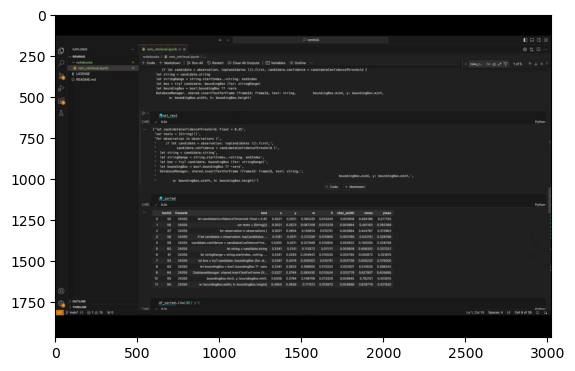

In [47]:
plt.imshow(frames[6])

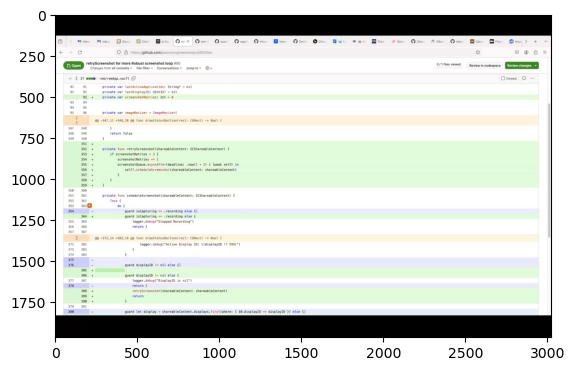

In [49]:
plt.imshow(frames[352])